# CDSM - Casual Inference using Deep Bayesian Dynamic Survival Models


This tutorial demonstrates the basic function of the causal dynamic survival model (CDSM).

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from utilss.data_simulator import get_data
from utilss.model import create_model, get_counterfactuals
from lifelines import KaplanMeierFitter


## Data simulation

To explore the finite-sample performance of CDSM, we ran several experiments with biologically plausible longitudinal
data following a previous study. Here, we demonstrate one experiment with the following settings:
<br>
- $5 \text{ continuous covariates }X(0)_1,X(0)_2,\dots,X(0)_D\sim\mathrm{N}(0,0.5)$
- $5 \text{ time invariant binary covariates }X_{D+1},X_{D+2},\dots,X_{2D}\sim\mathrm{Binom}(0.5)$
- A binary exposure generated at time 0 with the indicator function $A=I(\sum_{i=1}^DX(0)_i\geq\frac{\eta}{D}\sum_{i=1}^DX(0)_i )$,
where $\eta$ controls the balance of treated and control observations in the sample, with $100(1.5-\eta)\%$ of the sample receiving the treatment; and
- Individual survival curves generated using the hazard function $h_i(t) = \frac{\log(t)}{\lambda}\big(\beta_0 A_i+\beta_1\sum_{i=1}^5 X(t)_i+\beta_2\sum_{i=6}^{10} X(t)_i\big)$
- The event/censor time are generated using the root finding technique according to our original work.


In [3]:
print("simulating..." )
max_time = 30
data, val_data, test_data, train_stat, val_stat, test_stat,surv_func_wrapper, train_full, val_full, test_full, raw= \
get_data(input_dim= 5 , sampleSize= 1200, max_time=max_time,prediction_itvl = 1, history_itvl=14, overlap=1,
         seed= np.random.random_integers(1,1000), std = 0.1)
print("simulation completed" )

simulating...
simulation completed


<ipython-input-3-6794791e0c20>:5: DeprecationWarning: This function is deprecated. Please call randint(1, 1000 + 1) instead
  seed= np.random.random_integers(1,1000), std = 0.1)


In [4]:
rnn_x, rnn_m, rnn_s, rnn_y, Time = data #estimation data set
rnn_x_test, rnn_m_test, rnn_s_test, rnn_y_test, Time_test = test_data
rnn_x_val, rnn_m_val, rnn_s_val, rnn_y_val, Time_val = val_data

print("training covariate shape (sample size * history * covariate dimension + 1 (for treatment condition)):", rnn_x.shape)
print("validation covariate shape:", rnn_x_val.shape)
print("testing covariate shape:", rnn_x_test.shape)

training covariate shape (sample size * history * covariate dimension + 1 (for treatment condition)): (842, 14, 6)
validation covariate shape: (241, 14, 6)
testing covariate shape: (121, 14, 6)


In [5]:
trueSurv_wrapper = surv_func_wrapper(train_full, train_full.A, len(train_stat), t_start=0, max_time=max_time,plot=False)
trueSurv, trueSurv_1, trueSurv_0 = trueSurv_wrapper
cf_true = np.cumprod(trueSurv_1, 1) - np.cumprod(trueSurv_0, 1)


In [6]:
y_pred0_t = KaplanMeierFitter().fit(train_stat[train_stat[:, 3] == 0, 1], event_observed=train_stat[train_stat[:, 3] == 0, 2])
y_pred1_t = KaplanMeierFitter().fit(train_stat[train_stat[:, 3] == 1, 1], event_observed=train_stat[train_stat[:, 3] == 1, 2])
y_pred_t =  KaplanMeierFitter().fit(train_stat[:, 1], event_observed=train_stat[:, 2])

km_idx = y_pred_t.survival_function_.index.values
s_km = y_pred_t.survival_function_.KM_estimate
cf_km = y_pred0_t.survival_function_.KM_estimate - y_pred1_t.survival_function_.KM_estimate

The average of simulated individual survival curves (red solid line) and the Kaplan Meier estimator (dashed black line).

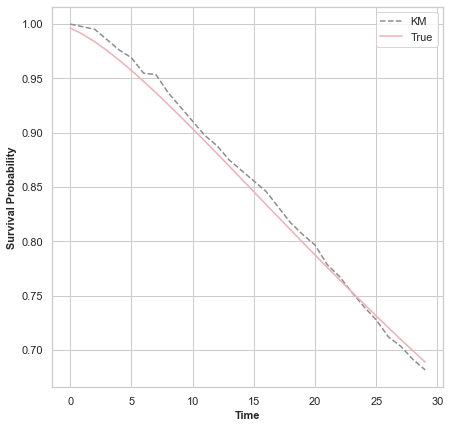

In [7]:
sns.set(style="whitegrid", font_scale=1)
fig, ax = plt.subplots(figsize=(7, 7))
t_surv = np.cumprod(trueSurv[:,1:max_time+1],1)
ax.plot(km_idx[0:-1], s_km.iloc[0:-1], color="#8c8c8c", label="KM", ls = "--")
ax.plot(range(max_time), np.mean(t_surv, 0), color="#f0aeb4", label="True")
ax.set_xlabel("Time", fontsize=11, fontweight='bold')
ax.set_ylabel("Survival Probability", fontsize=11, fontweight='bold')
plt.legend()
plt.show()

## Model training

In [8]:
# Train the model
#max_time: max follow-up time
#history_itvl: max history window
#data: estimation data set
#val_data: validation data set
#lstm_window: number of lstm units
#alpha: weight for partial likelihood loss
#beta: weight for rank/concordance loss
#gamma: weight for selection bias loss
#verbose: 0: disbale system message; 1: enable system message
#layers: depth of dense layers in of potential outcome sub-network
modelCDSM,model_p, history_dict = create_model(rnn_x.shape[2], max_time, 14, data, val_data, lstm_window= 7,
                                            alpha= 2, beta= 1, gamma=1.2, load=False, verbose=0, model_name='cox',
                                            batch_size= 256, layers=3)

modelCDSM_result = get_counterfactuals(modelCDSM, data, t=0, draw=10, test_data=test_data)
print('traning completed!')



fit propensity
fit main model
Instructions for updating:
Please use `layer.add_weight` method instead.

traning completed!


The average of simulated individual survival curves (red solid line); the light red band is the upper and lower
25% quantile of the true survival probability at each time point; the light blue band is the upper and lower 25% quantile
of estimated survival probability at each time point.

estimated survival curves


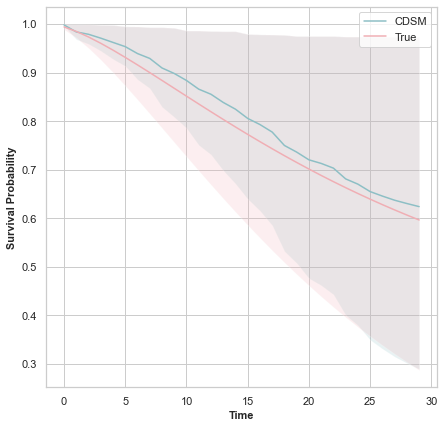

In [72]:
y_pred_t, y_pred_std, y_pred1_t, y_pred0_t, cf_std_1, _, \
y_pred_t_test, y_pred_std_test, y_pred1_t_test, y_pred0_t_test, cf_std_1_test, _ = modelCDSM_result
s_durv = np.cumprod(y_pred_t, 1)
cf_durv = np.cumprod(y_pred1_t, 1) - np.cumprod(y_pred0_t, 1)
hr_durv = np.clip(y_pred0_t, 0.001, 1) / np.clip(y_pred1_t, 0.001, 1)


print('estimated survival curves')

sns.set(style="whitegrid", font_scale=1)
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(range(max_time), np.mean(s_durv, 0), color="#8DBFC5", label="CDSM")
ax.plot(range(max_time), np.mean(t_surv, 0), color="#f0aeb4", label="True")
ax.fill_between(range(max_time), np.quantile(s_durv, q = 0.25, axis = 0), np.quantile(s_durv, q = 0.75, axis = 0),
               facecolor='#8DBFC5', alpha=0.2)
ax.fill_between(range(max_time), np.quantile(t_surv, q = 0.25, axis = 0), np.quantile(s_durv, q = 0.75, axis = 0),
               facecolor='#f0aeb4', alpha=0.2)
ax.set_xlabel("Time", fontsize=11, fontweight='bold')
ax.set_ylabel("Survival Probability", fontsize=11, fontweight='bold')
plt.legend()
plt.show()

estimated difference in survival curves


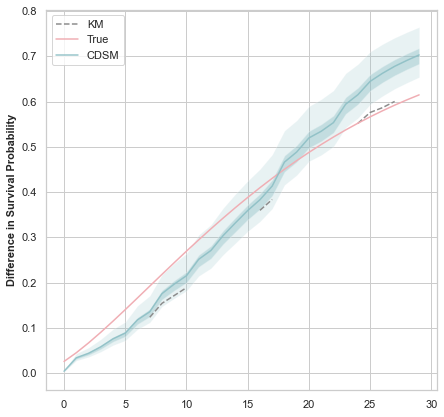

In [61]:
print('estimated difference in survival curves')

sns.set(style="whitegrid", font_scale=1)
fig, ax = plt.subplots(figsize=(7, 7))
ax.plot(range(max_time), -np.mean(cf_true[:,2:max_time+2], 0), color="#f0aeb4", label="True")
ax.plot(range(max_time), np.mean(cf_durv, 0), color='#8DBFC5', alpha=0.9, label="CDSM")
ax.fill_between(range(max_time), np.quantile(cf_durv, q = 0.25, axis = 0), np.quantile(cf_durv, q = 0.75, axis = 0),
               facecolor='#8DBFC5', alpha=0.4)
ax.fill_between(range(max_time), np.quantile(cf_durv, q = 0.05, axis = 0), np.quantile(cf_durv, q = 0.95, axis = 0),
               facecolor='#8DBFC5', alpha=0.2)
#ax.set_xticklabels(np.arange(-8,max_time*3,8))
#ax.set_xlabel("Months", fontsize=11, fontweight='bold')
ax.set_ylabel("Difference in Survival Probability", fontsize=11, fontweight='bold')
plt.legend()
plt.show()


